<a href="https://colab.research.google.com/github/zzzzzssyy/ECON3916-33674-Statistical-Machine-Learning/blob/main/Lab%204/Lab_4_Descriptive_Statistics_%26_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64


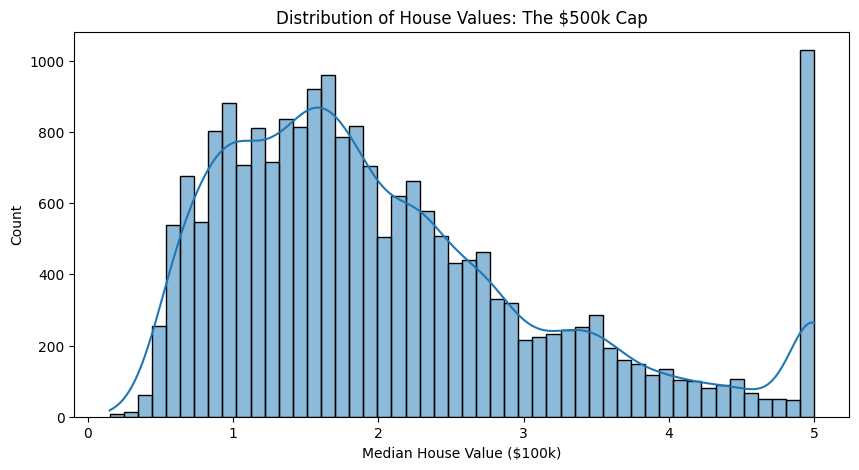

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. Ingest Data
data = fetch_california_housing(as_frame=True)
df = data.frame

# 2. Inspect the "Ceiling Effect"
print(df['MedHouseVal'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['MedHouseVal'], bins=50, kde=True)
plt.title("Distribution of House Values: The $500k Cap")
plt.xlabel("Median House Value ($100k)")
plt.show()

In [3]:
def flag_outliers_iqr(df, column):
    # Calculate Quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the "Tukey Fence"
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return Boolean Mask
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Apply to Median Income
df['outlier_iqr'] = flag_outliers_iqr(df, 'MedInc')

print(f"Manual Outliers Detected: {df['outlier_iqr'].sum()}")
print("These are primarily the 'Wealthy' districts.")

Manual Outliers Detected: 681
These are primarily the 'Wealthy' districts.


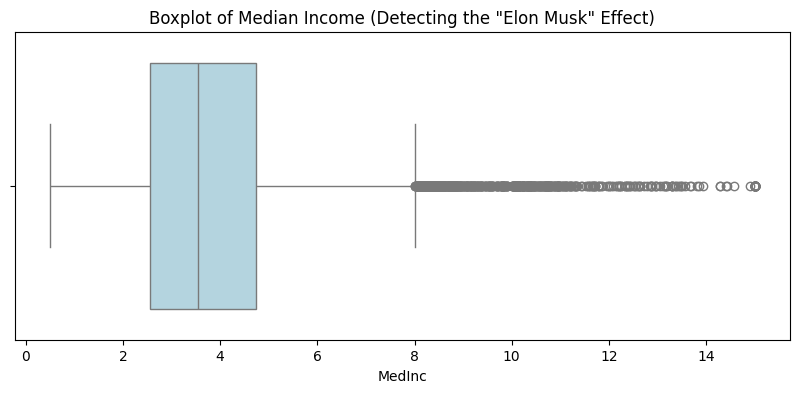

In [4]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MedInc'], color='lightblue')
plt.title('Boxplot of Median Income (Detecting the "Elon Musk" Effect)')
plt.show()

In [5]:
# Initialize the model
# contamination=0.05: We estimate ~5% of the data is anomalous
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Features to analyze (Income, House Age, Average Rooms)
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']

# Fit and Predict (-1 = Outlier, 1 = Normal)
preds = iso_forest.fit_predict(df[features])

# Map to boolean (True if outlier)
df['outlier_iso'] = preds == -1

print(f"Algorithmic Outliers Detected: {df['outlier_iso'].sum()}")

Algorithmic Outliers Detected: 1032


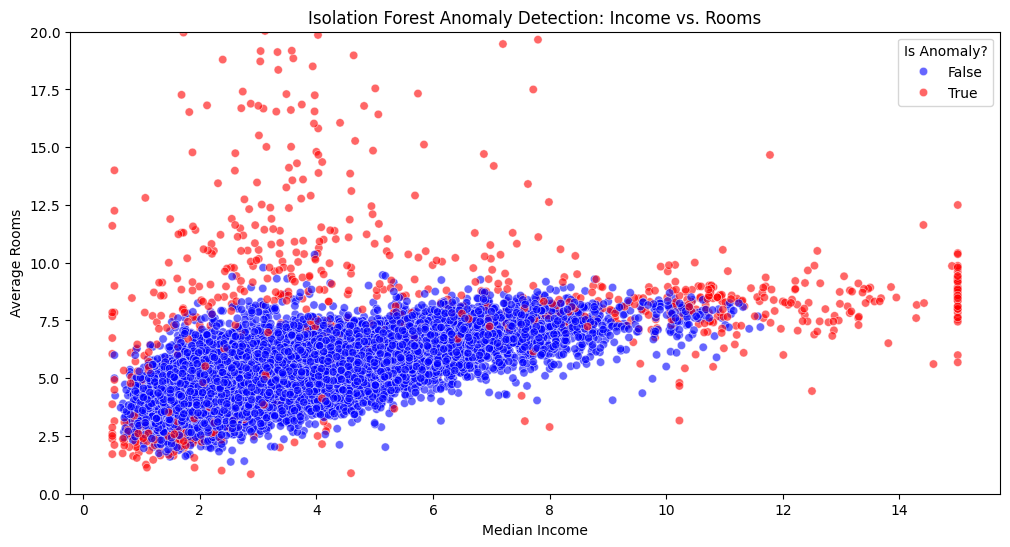

In [8]:
plt.figure(figsize=(12, 6))

# Plot points flagged by Isolation Forest
sns.scatterplot(
    data=df,
    x='MedInc',
    y='AveRooms',
    hue='outlier_iso',
    palette={True: 'red', False: 'blue'},
    alpha=0.6
)

plt.title("Isolation Forest Anomaly Detection: Income vs. Rooms")
plt.xlabel("Median Income")
plt.ylabel("Average Rooms")
plt.ylim(0, 20) # Zoom in to ignore extreme errors
plt.legend(title='Is Anomaly?')
plt.show()

Normal points: 19608
Outlier points: 1032

COMPARATIVE FORENSICS REPORT: Normal vs Outlier Analysis

📊 CENTRAL TENDENCY METRICS
--------------------------------------------------------------------------------
  Group  Count  MedInc_Mean  MedInc_Median  MedHouseVal_Mean  MedHouseVal_Median
 Normal  19608     3.769613        3.51560          2.037000               1.789
Outlier   1032     5.790782        4.25695          2.668172               2.057

📈 VOLATILITY METRICS (Standard Deviation vs MAD)
--------------------------------------------------------------------------------
  Group  MedInc_StdDev  MedInc_MAD  MedHouseVal_StdDev  MedHouseVal_MAD
 Normal       1.640561     1.03165            1.114117            0.674
Outlier       4.145354     2.49190            1.634770            1.103

⚠️  INEQUALITY WEDGE ANALYSIS (Mean - Median)
--------------------------------------------------------------------------------
A larger wedge indicates positive skewness (heavy right tail)
-----------

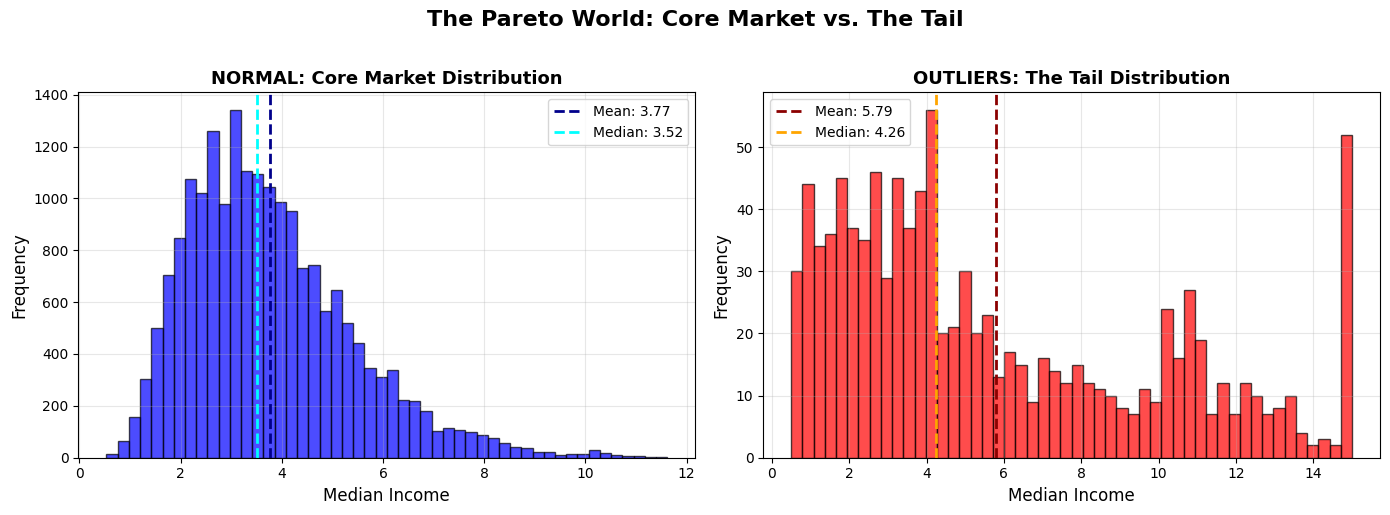


Report Complete!


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

# Task 1: Split the data into two DataFrames
df_normal = df[df['outlier_iso'] == False].copy()
df_outlier = df[df['outlier_iso'] == True].copy()

print(f"Normal points: {len(df_normal)}")
print(f"Outlier points: {len(df_outlier)}")
print("=" * 80)

# Task 2: Calculate Mean and Median for both groups
def calculate_statistics(data, label):
    """Calculate comprehensive statistics for a dataset"""
    stats = {
        'Group': label,
        'Count': len(data),
        'MedInc_Mean': data['MedInc'].mean(),
        'MedInc_Median': data['MedInc'].median(),
        'MedHouseVal_Mean': data['MedHouseVal'].mean(),
        'MedHouseVal_Median': data['MedHouseVal'].median(),
    }
    return stats

normal_stats = calculate_statistics(df_normal, 'Normal')
outlier_stats = calculate_statistics(df_outlier, 'Outlier')

# Task 3: Calculate Standard Deviation vs MAD
def calculate_volatility(data, label):
    """Calculate volatility metrics using StdDev and MAD"""
    volatility = {
        'Group': label,
        'MedInc_StdDev': data['MedInc'].std(),
        'MedInc_MAD': median_abs_deviation(data['MedInc'], nan_policy='omit'),
        'MedHouseVal_StdDev': data['MedHouseVal'].std(),
        'MedHouseVal_MAD': median_abs_deviation(data['MedHouseVal'], nan_policy='omit'),
    }
    return volatility

normal_volatility = calculate_volatility(df_normal, 'Normal')
outlier_volatility = calculate_volatility(df_outlier, 'Outlier')

# Create comprehensive summary report
print("\n" + "=" * 80)
print("COMPARATIVE FORENSICS REPORT: Normal vs Outlier Analysis")
print("=" * 80)

# Central Tendency Comparison
print("\n📊 CENTRAL TENDENCY METRICS")
print("-" * 80)
summary_df = pd.DataFrame([normal_stats, outlier_stats])
print(summary_df.to_string(index=False))

# Volatility Comparison
print("\n📈 VOLATILITY METRICS (Standard Deviation vs MAD)")
print("-" * 80)
volatility_df = pd.DataFrame([normal_volatility, outlier_volatility])
print(volatility_df.to_string(index=False))

# Task 4: Inequality Wedge Analysis
print("\n⚠️  INEQUALITY WEDGE ANALYSIS (Mean - Median)")
print("-" * 80)
print("A larger wedge indicates positive skewness (heavy right tail)")
print("-" * 80)

inequality_wedge = {
    'Metric': ['MedInc', 'MedHouseVal'],
    'Normal_Wedge': [
        normal_stats['MedInc_Mean'] - normal_stats['MedInc_Median'],
        normal_stats['MedHouseVal_Mean'] - normal_stats['MedHouseVal_Median']
    ],
    'Outlier_Wedge': [
        outlier_stats['MedInc_Mean'] - outlier_stats['MedInc_Median'],
        outlier_stats['MedHouseVal_Mean'] - outlier_stats['MedHouseVal_Median']
    ]
}

wedge_df = pd.DataFrame(inequality_wedge)
wedge_df['Wedge_Difference'] = wedge_df['Outlier_Wedge'] - wedge_df['Normal_Wedge']
print(wedge_df.to_string(index=False))

# Interpretation
print("\n💡 KEY INSIGHTS:")
print("-" * 80)
medinc_wedge_ratio = (outlier_stats['MedInc_Mean'] - outlier_stats['MedInc_Median']) / \
                      (normal_stats['MedInc_Mean'] - normal_stats['MedInc_Median']) \
                      if (normal_stats['MedInc_Mean'] - normal_stats['MedInc_Median']) != 0 else np.inf

print(f"• Outlier Income Wedge is {medinc_wedge_ratio:.2f}x larger than Normal")
print(f"• Outlier group shows {'higher' if outlier_volatility['MedInc_StdDev'] > normal_volatility['MedInc_StdDev'] else 'lower'} volatility")
print(f"• MAD/StdDev ratio (Normal): {normal_volatility['MedInc_MAD']/normal_volatility['MedInc_StdDev']:.3f}")
print(f"• MAD/StdDev ratio (Outlier): {outlier_volatility['MedInc_MAD']/outlier_volatility['MedInc_StdDev']:.3f}")
print("  (Lower ratio suggests more extreme outliers within the group)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Normal Distribution
axes[0].hist(df_normal['MedInc'], bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0].axvline(df_normal['MedInc'].mean(), color='darkblue', linestyle='--', linewidth=2, label=f"Mean: {df_normal['MedInc'].mean():.2f}")
axes[0].axvline(df_normal['MedInc'].median(), color='cyan', linestyle='--', linewidth=2, label=f"Median: {df_normal['MedInc'].median():.2f}")
axes[0].set_xlabel('Median Income', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('NORMAL: Core Market Distribution', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Outlier Distribution
axes[1].hist(df_outlier['MedInc'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[1].axvline(df_outlier['MedInc'].mean(), color='darkred', linestyle='--', linewidth=2, label=f"Mean: {df_outlier['MedInc'].mean():.2f}")
axes[1].axvline(df_outlier['MedInc'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {df_outlier['MedInc'].median():.2f}")
axes[1].set_xlabel('Median Income', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('OUTLIERS: The Tail Distribution', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle('The Pareto World: Core Market vs. The Tail',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("Report Complete!")
print("=" * 80)